In [1]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "brain_tumor_dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "Training"
TESTING_FOLER = DATASET_FOLER + "/" + "Testing"
IMAGE_HEIGHT=64
IMAGE_WIDTH=64
COLOR_MODE='rgb'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


['glioma', 'meningioma', 'notumor', 'pituitary']
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


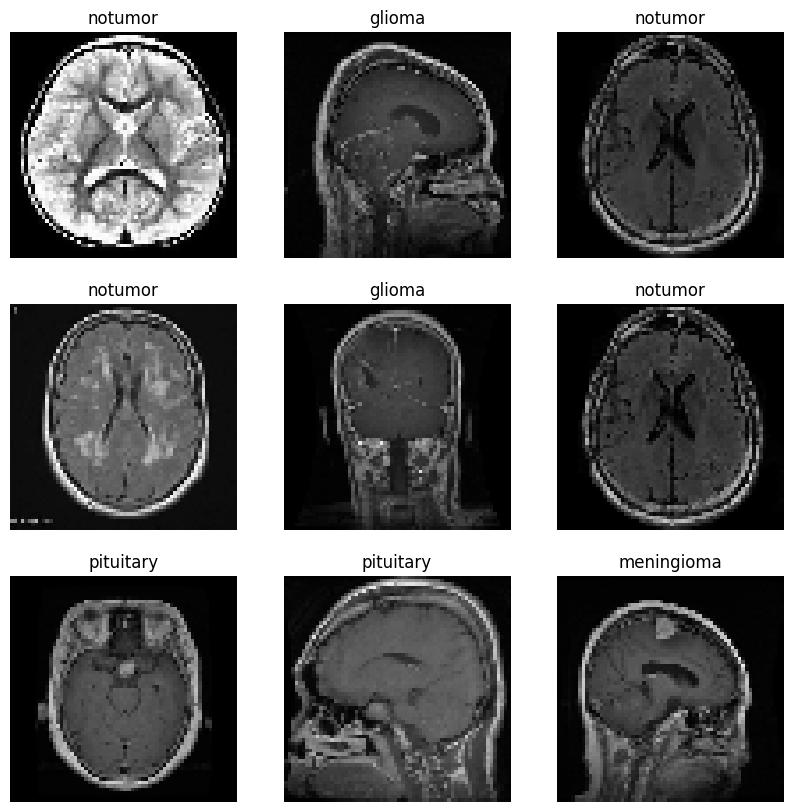

In [2]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dropout(0.4),

    keras.layers.Dense(4, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 64, 64, 3)         0         |
|                                                               |
| rescaling (Rescaling)     (None, 64, 64, 3)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                    

In [5]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
)

Epoch 1/100
143/143 [==============================] - 10s 38ms/step - loss: 0.7672 - sparse_categorical_accuracy: 0.6993 - val_loss: 3.0816 - val_sparse_categorical_accuracy: 0.4081
Epoch 2/100
143/143 [==============================] - 2s 15ms/step - loss: 0.5390 - sparse_categorical_accuracy: 0.7991 - val_loss: 4.8326 - val_sparse_categorical_accuracy: 0.3818
Epoch 3/100
143/143 [==============================] - 2s 14ms/step - loss: 0.4218 - sparse_categorical_accuracy: 0.8457 - val_loss: 3.5961 - val_sparse_categorical_accuracy: 0.4256
Epoch 4/100
143/143 [==============================] - 2s 14ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8696 - val_loss: 2.4825 - val_sparse_categorical_accuracy: 0.5744
Epoch 5/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3045 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.7653
Epoch 6/100
143/143 [==============================] - 2s 14ms/step - loss: 0.2690 - spar

Epochs run: 55


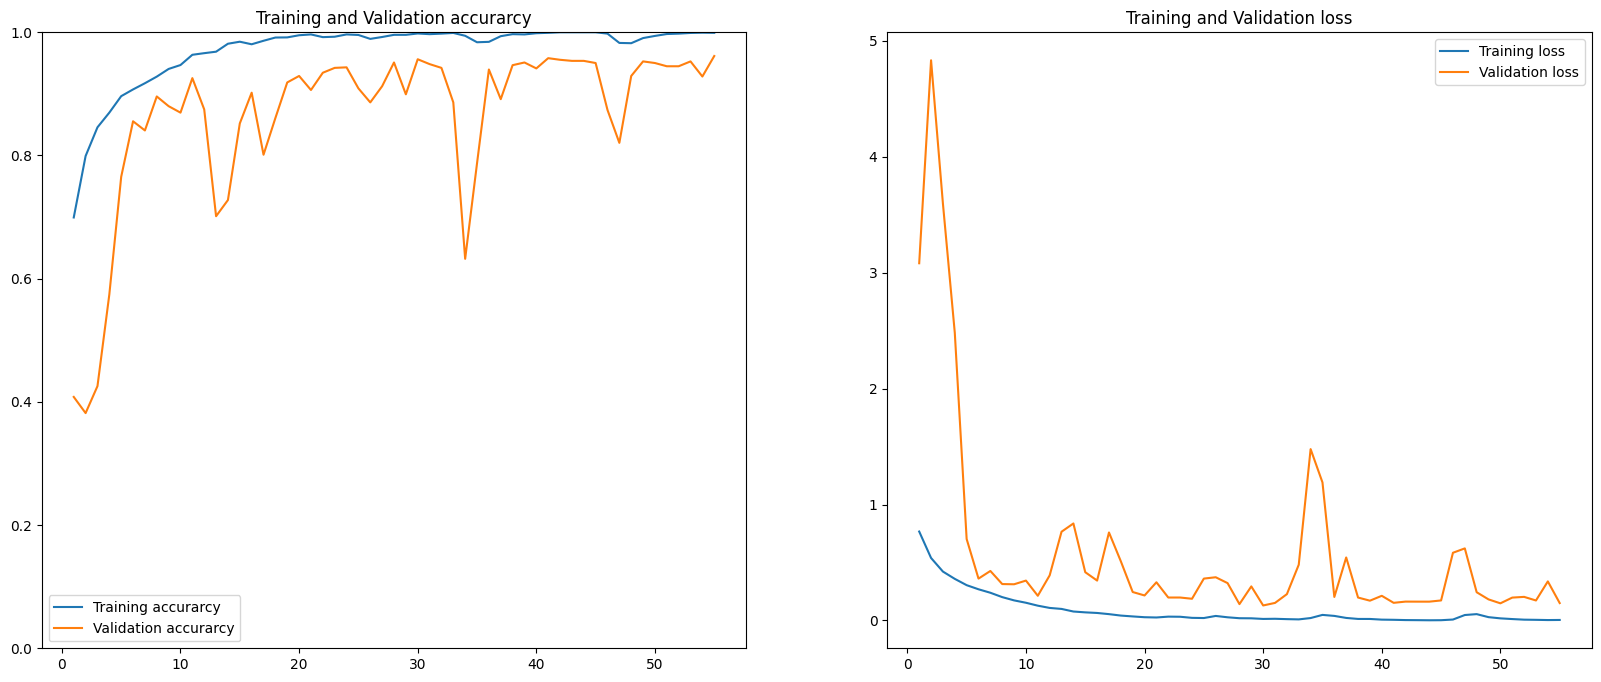

In [6]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [7]:
test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,color_mode=COLOR_MODE,)

results = model.evaluate(test_ds, verbose=0)

print("Test accuracy:", results[1]*100)
print("Test loss:", results[0]*100)

Found 1311 files belonging to 4 classes.
Test accuracy: 94.66056227684021
Test loss: 15.441744029521942


In [8]:
# SAVING THE MODEL

import pickle

# save the iris classification model
model.save("bt-cnn.h5")

In [9]:
import tensorflow as tf

model.save("bt-cnn.h5") 
loaded_model = tf.keras.models.load_model("bt-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


41/41 [==============================] - 1s 24ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9466


1/1 [==============================] - 0s 129ms/step
predicted_labels 1311 tf.Tensor([1 3 2 ... 3 1 2], shape=(1311,), dtype=int64)
true_labels 1311 tf.Tensor([1 3 2 ... 3 1 2], shape=(1311,), dtype=int32)
[[260  39   0   1]
 [  3 291   9   3]
 [  2   1 402   0]
 [  0  12   0 288]]


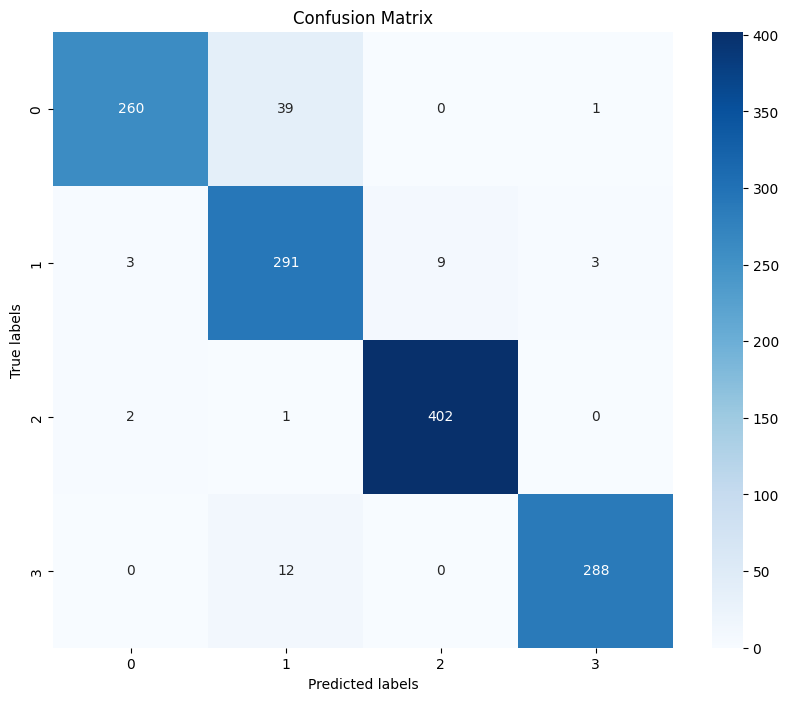

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print("predicted_labels", len(predicted_labels), predicted_labels)
print("true_labels", len(correct_labels), correct_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(correct_labels, predicted_labels)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import classification_report


print(classification_report(correct_labels, predicted_labels, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.98      0.87      0.92       300
  meningioma       0.85      0.95      0.90       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.99      0.96      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Assuming true_labels and predicted_labels are lists of labels for each class
# where true_labels[i] contains true labels and predicted_labels[i] contains predicted probabilities/scores for class i

# Compute ROC curve for each class
n_classes = len(correct_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[i], tpr[i], _ = roc_curve(correct_labels, predicted_labels)

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(correct_labels[i], predicted_labels[i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class CNN')
plt.legend(loc="lower right")
plt.show()

TypeError: got an unexpected keyword argument 'multi_class'